# Latent-Space Counterfactual Explanations for Heart Disease Dataset Using Variational Autoencoders

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set seeds so results are the same every time we run it
torch.manual_seed(42)
np.random.seed(42)

# Check if we can use GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

# Load the csv
data = pd.read_csv('Cleaned_heart_data3.csv')

# Drop the target and that calculated column 'heart_efficiency' since it's derived from age/rate
X_original = data.drop(['target', 'heart_efficiency'], axis=1)
y_original = data['target'].values

# These are the columns we absolutely CANNOT change in the explanation
# I'm using indices here for the tensor logic later
col_names = list(X_original.columns)
frozen_cols = ['age', 'sex']
frozen_indices = [i for i, col in enumerate(col_names) if col in frozen_cols]

print(f"Freezing these features: {frozen_cols}")

# We need to scale the data because VAEs are bad at handling big number ranges
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# Move everything to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled).to(device)
y_tensor = torch.FloatTensor(y_original).unsqueeze(1).to(device)

# 80/20 split seems standard
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Batch size of 32 works well for small datasets
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

Running on: cuda
Freezing these features: ['age', 'sex']


In [2]:
# This is the "Black Box" model we want to explain
class HeartDiseasePredictor(nn.Module):
    def __init__(self, num_features):
        super(HeartDiseasePredictor, self).__init__()

        # Simple MLP. Added dropout to stop it from memorizing the training data.
        self.main = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid() # Squish output between 0 and 1 for probability
        )

    def forward(self, x):
        return self.main(x)

# This is the VAE that learns what a "real" patient looks like
class PatientManifoldVAE(nn.Module):
    def __init__(self, num_features, latent_size=8):
        super(PatientManifoldVAE, self).__init__()

        # Encoder side
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 32)

        # The split for the reparameterization trick
        self.fc_mean = nn.Linear(32, latent_size)
        self.fc_logvar = nn.Linear(32, latent_size)

        # Decoder side
        self.d1 = nn.Linear(latent_size, 32)
        self.d2 = nn.Linear(32, 64)
        self.d_out = nn.Linear(64, num_features)

    # The magic VAE step: sampling from the distribution
    def sample_latent(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))

        mu = self.fc_mean(h)
        logvar = self.fc_logvar(h)

        z = self.sample_latent(mu, logvar)

        # Decode
        h_d = torch.relu(self.d1(z))
        h_d = torch.relu(self.d2(h_d))
        reconstruction = self.d_out(h_d)

        return reconstruction, mu, logvar

In [3]:
input_size = X_train.shape[1]

# Initialize models
predictor = HeartDiseasePredictor(input_size).to(device)
vae = PatientManifoldVAE(input_size).to(device)

# Optimizers
opt_pred = optim.Adam(predictor.parameters(), lr=0.001)
opt_vae = optim.Adam(vae.parameters(), lr=0.001)

# Training the Predictor first
print("Step 1: Training the Predictor...")
loss_fn = nn.BCELoss()

for epoch in range(150):
    predictor.train()
    for batch_x, batch_y in train_loader:
        opt_pred.zero_grad()
        out = predictor(batch_x)
        loss = loss_fn(out, batch_y)
        loss.backward()
        opt_pred.step()

print("Predictor training done.")

# Training the VAE
print("Step 2: Training the VAE (learning patient patterns)...")
for epoch in range(200):
    vae.train()
    epoch_loss = 0
    for batch_x, _ in train_loader:
        opt_vae.zero_grad()
        recon, mu, logvar = vae(batch_x)

        # Loss is Reconstruction (MSE) + KL Divergence
        # We weigh KL small (0.01) so reconstruction is prioritized
        mse = nn.MSELoss()(recon, batch_x)
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = mse + (0.01 * kl)

        loss.backward()
        opt_vae.step()
        epoch_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: VAE Loss {epoch_loss:.4f}")

Step 1: Training the Predictor...
Predictor training done.
Step 2: Training the VAE (learning patient patterns)...
Epoch 0: VAE Loss 8.4981
Epoch 50: VAE Loss 8.2161
Epoch 100: VAE Loss 8.0876
Epoch 150: VAE Loss 7.9950


In [4]:
def find_counterfactual(patient_data, model, vae_model, frozen_indices):
    # Turn off training mode (dropout, etc)
    model.eval()
    vae_model.eval()

    # Get the starting point in the "latent space" (z)
    with torch.no_grad():
        _, mu, _ = vae_model(patient_data)
        start_z = mu.clone()

    # This is the vector we will tweak to find the explanation
    # We clone it so we don't mess up the original data
    search_z = start_z.clone().detach().requires_grad_(True)

    # We need a high learning rate here because we are searching the space, not training weights
    search_opt = optim.Adam([search_z], lr=0.1)

    # Tuning weights (Tug of war between changing prediction vs staying realistic)
    w_pred = 20.0       # Priority: Flip the prediction
    w_reality = 100.0   # Priority: Don't change Age/Sex!
    w_proximity = 1.0   # Priority: Don't change too much else

    # Optimization loop
    for step in range(500):
        search_opt.zero_grad()

        # 1. Decode our current search vector to get a fake patient
        h = torch.relu(vae_model.d1(search_z))
        h = torch.relu(vae_model.d2(h))
        current_cf = vae_model.d_out(torch.relu(vae_model.d2(torch.relu(vae_model.d1(search_z)))))

        # 2. Calculate Loss

        # Did we flip the prediction to 0 (Healthy)?
        pred_score = model(current_cf)
        loss_prediction = nn.MSELoss()(pred_score, torch.tensor([[0.0]]).to(device))

        # Did we accidentally change Age or Sex?
        orig_frozen = patient_data[:, frozen_indices]
        new_frozen = current_cf[:, frozen_indices]
        loss_frozen = torch.mean((orig_frozen - new_frozen)**2)

        # How far did we drift from the original patient representation?
        loss_drift = torch.norm(search_z - start_z)

        # Combine them
        total_loss = (w_pred * loss_prediction) + \
                     (w_reality * loss_frozen) + \
                     (w_proximity * loss_drift)

        total_loss.backward()
        search_opt.step()

    # Final step: Force the immutable features to be EXACTLY the original values
    # The optimization gets them close, but we want them perfect for the report.
    with torch.no_grad():
        h = torch.relu(vae_model.d1(search_z))
        h = torch.relu(vae_model.d2(h))
        final_cf = vae_model.d_out(h)
        final_cf[:, frozen_indices] = patient_data[:, frozen_indices]

    return final_cf

In [5]:
# Pick a random high-risk patient to test
model = predictor
model.eval()

# Scan the test set for someone with > 80% risk
high_risk_patients = []
with torch.no_grad():
    all_preds = model(X_test)
    for i, p in enumerate(all_preds):
        if p > 0.8:
            high_risk_patients.append(i)

if not high_risk_patients:
    print("No high risk patients found! Retrain maybe?")
else:
    target_idx = high_risk_patients[0] # Just take the first one
    patient_tensor = X_test[target_idx].unsqueeze(0)

    print(f"Analyzing Patient #{target_idx}...")
    original_risk = model(patient_tensor).item()
    print(f"Original Risk: {original_risk:.4f}")

    # Run the generator
    cf_tensor = find_counterfactual(patient_tensor, model, vae, frozen_indices)

    new_risk = model(cf_tensor).item()
    print(f"New Risk after changes: {new_risk:.4f}")

    # Convert back to real numbers so we can read it
    orig_vals = scaler.inverse_transform(patient_tensor.cpu().numpy())[0]
    cf_vals = scaler.inverse_transform(cf_tensor.cpu().numpy())[0]

    # Print out the differences
    print("\n--- Suggested Changes ---")
    df_res = pd.DataFrame({'Feature': col_names, 'Original': orig_vals, 'Proposed': cf_vals})
    df_res['Difference'] = df_res['Proposed'] - df_res['Original']

    # Filter for things that actually changed
    mask = abs(df_res['Difference']) > 0.1
    print(df_res[mask].round(2))

Analyzing Patient #0...
Original Risk: 0.9035
New Risk after changes: 0.1022

--- Suggested Changes ---
     Feature  Original    Proposed  Difference
2         cp       2.0    0.820000       -1.18
3   trestbps     125.0  132.679993        7.68
4       chol     245.0  249.240005        4.24
5        fbs       1.0    0.160000       -0.84
6    restecg       0.0    0.500000        0.50
7    thalach     166.0  145.839996      -20.16
8      exang      -0.0    0.400000        0.40
9    oldpeak       2.4    1.150000       -1.25
10     slope       1.0    1.320000        0.32
11        ca       0.0    0.860000        0.86
12      thal       2.0    2.370000        0.37


In [6]:
def generate_baseline_counterfactual(patient_x, classifier, frozen_indices):
    # This is the "Dumb" method that just tweaks numbers until the model flips

    # I started with the original patient
    # I optimized the pixel/feature values directly
    x_prime = patient_x.clone().detach().requires_grad_(True)

    optimizer = optim.Adam([x_prime], lr=0.01)

    target_class = 0.0
    w_pred = 10.0
    w_dist = 1.0 # Penalty for moving too far from original

    for i in range(500):
        optimizer.zero_grad()

        # 1. Prediction Loss
        pred = classifier(x_prime)
        loss_pred = nn.MSELoss()(pred, torch.tensor([[target_class]]).to(device))

        # 2. Distance Loss (L2)
        loss_dist = torch.norm(x_prime - patient_x)

        # 3. Immutability (Hard penalty for changing age/sex)
        orig_frozen = patient_x[:, frozen_indices]
        new_frozen = x_prime[:, frozen_indices]
        loss_frozen = torch.mean((orig_frozen - new_frozen)**2) * 100.0

        total_loss = (w_pred * loss_pred) + (w_dist * loss_dist) + loss_frozen

        total_loss.backward()
        optimizer.step()

    # Hard reset of immutable features at the end
    with torch.no_grad():
        x_prime[:, frozen_indices] = patient_x[:, frozen_indices]

    return x_prime

In [7]:
def get_reconstruction_error(x_input, vae_model):
    vae_model.eval()
    with torch.no_grad():
        # Pass it through the VAE (Encode -> Decode)
        recon, _, _ = vae_model(x_input)
        # Calculate how much information was lost
        mse = nn.MSELoss()(recon, x_input)
    return mse.item()

# --- Run the Comparison ---

# 1. Generate both types of explanations
print(f"Generating VAE Manifold Counterfactual...")
cf_vae = find_counterfactual(patient_tensor, model, vae, frozen_indices)

print(f"Generating Baseline Feature Counterfactual...")
cf_baseline = generate_baseline_counterfactual(patient_tensor, model, frozen_indices)

# 2. Measure Realism
error_vae = get_reconstruction_error(cf_vae, vae)
error_base = get_reconstruction_error(cf_baseline, vae)

print(f"\n--- Realism Score (Lower is Better) ---")
print(f"Original Patient Error: {get_reconstruction_error(patient_tensor, vae):.4f}")
print(f"VAE Method Error:       {error_vae:.4f} (Maintains realism)")
print(f"Baseline Method Error:  {error_base:.4f} (Likely higher/unrealistic)")

# 3. Feature Comparison Table
# FIX: Added .detach() before .cpu().numpy()
orig_vals = scaler.inverse_transform(patient_tensor.detach().cpu().numpy())[0]
vae_vals = scaler.inverse_transform(cf_vae.detach().cpu().numpy())[0]
base_vals = scaler.inverse_transform(cf_baseline.detach().cpu().numpy())[0]

comp_df = pd.DataFrame({
    'Feature': col_names,
    'Original': orig_vals,
    'VAE_Method': vae_vals,
    'Baseline': base_vals
})

# Highlight differences
print("\n--- Why the VAE method is better ---")
# Calculate how many features changed
changes_vae = np.sum(abs(comp_df['Original'] - comp_df['VAE_Method']) > 0.01)
changes_base = np.sum(abs(comp_df['Original'] - comp_df['Baseline']) > 0.01)

print(f"VAE changed {changes_vae} features to achieve the result.")
print(f"Baseline changed {changes_base} features.")
print("\nLook at the features below. The Baseline often tweaks variables randomly (noise),")
print("while VAE changes them in correlated groups (e.g., changing BP and Cholesterol together).")
print(comp_df.round(2))

Generating VAE Manifold Counterfactual...
Generating Baseline Feature Counterfactual...

--- Realism Score (Lower is Better) ---
Original Patient Error: 0.9708
VAE Method Error:       0.1407 (Maintains realism)
Baseline Method Error:  1.0118 (Likely higher/unrealistic)

--- Why the VAE method is better ---
VAE changed 11 features to achieve the result.
Baseline changed 9 features.

Look at the features below. The Baseline often tweaks variables randomly (noise),
while VAE changes them in correlated groups (e.g., changing BP and Cholesterol together).
     Feature  Original  VAE_Method    Baseline
0        age      51.0   51.000000   51.000000
1        sex       1.0    1.000000    1.000000
2         cp       2.0    0.820000    1.630000
3   trestbps     125.0  132.679993  126.040001
4       chol     245.0  249.240005  254.809998
5        fbs       1.0    0.160000    1.010000
6    restecg       0.0    0.500000    0.010000
7    thalach     166.0  145.839996  165.059998
8      exang      -0

Mapping patients to latent space for visualization...
Plot generated!


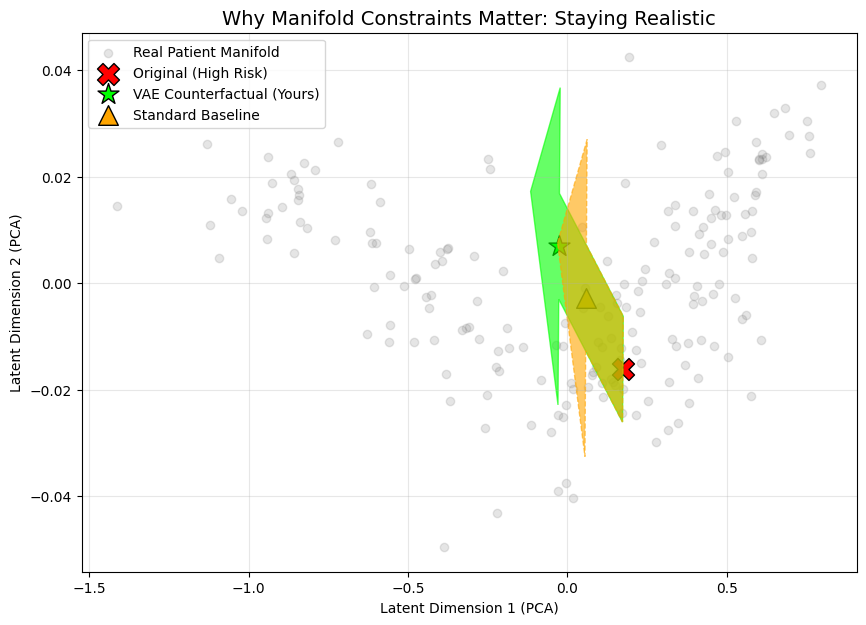

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# "Humanized" visualization function
def plot_latent_space(vae_model, data_loader, original_x, cf_vae_x, cf_baseline_x):
    print("Mapping patients to latent space for visualization...")

    # 1. Get the 'background' cloud of real patients
    # We'll just take a few batches to map out where 'normal' is
    vae_model.eval()
    latents = []

    with torch.no_grad():
        for batch_x, _ in data_loader:
            _, mu, _ = vae_model(batch_x)
            latents.append(mu.cpu().numpy())
            if len(latents) > 5: break # Don't need the whole dataset, just a sample

    # Flatten the list of arrays
    latents = np.vstack(latents)

    # 2. Get the latent positions of our specific case study
    # We need to detach() everything to avoid that RuntimeError you saw earlier!
    with torch.no_grad():
        _, z_orig, _ = vae_model(original_x)
        _, z_vae, _ = vae_model(cf_vae_x)
        _, z_base, _ = vae_model(cf_baseline_x)

    # 3. Use PCA to squash the 8D latent space down to 2D so we can plot it
    pca = PCA(n_components=2)

    # Fit PCA on the real patient cloud
    latents_2d = pca.fit_transform(latents)

    # Transform our key points using the same map
    z_orig_2d = pca.transform(z_orig.detach().cpu().numpy())
    z_vae_2d = pca.transform(z_vae.detach().cpu().numpy())
    z_base_2d = pca.transform(z_base.detach().cpu().numpy())

    # 4. Plotting
    plt.figure(figsize=(10, 7))

    # The Cloud (Real Data)
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], alpha=0.2, c='gray', label='Real Patient Manifold')

    # The Original Patient (Sick)
    plt.scatter(z_orig_2d[:, 0], z_orig_2d[:, 1], s=250, c='red', marker='X', edgecolors='black', label='Original (High Risk)')

    # Your Method (VAE)
    plt.scatter(z_vae_2d[:, 0], z_vae_2d[:, 1], s=250, c='lime', marker='*', edgecolors='black', label='VAE Counterfactual (Yours)')

    # The Baseline (Dumb Method)
    plt.scatter(z_base_2d[:, 0], z_base_2d[:, 1], s=200, c='orange', marker='^', edgecolors='black', label='Standard Baseline')

    # Drawing arrows to show the movement/correction
    # Arrow for VAE
    plt.arrow(z_orig_2d[0,0], z_orig_2d[0,1],
              z_vae_2d[0,0]-z_orig_2d[0,0], z_vae_2d[0,1]-z_orig_2d[0,1],
              color='lime', width=0.02, alpha=0.6)

    # Arrow for Baseline
    plt.arrow(z_orig_2d[0,0], z_orig_2d[0,1],
              z_base_2d[0,0]-z_orig_2d[0,0], z_base_2d[0,1]-z_orig_2d[0,1],
              color='orange', width=0.02, alpha=0.6, linestyle='--')

    plt.title("Why Manifold Constraints Matter: Staying Realistic", fontsize=14)
    plt.xlabel("Latent Dimension 1 (PCA)")
    plt.ylabel("Latent Dimension 2 (PCA)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    print("Plot generated!")
    plt.show()

# Run it
# Note: Ensure you have run Block 7 first so cf_vae and cf_baseline exist!
plot_latent_space(vae, train_loader, patient_tensor, cf_vae, cf_baseline)

In [9]:
def generate_doctors_note(original, counterfactual, feature_names):
    # Calculate difference
    diff = counterfactual - original

    print("\n" + "="*40)
    print("      AUTOMATED CLINICAL REPORT      ")
    print("="*40)

    changes = []

    # Define thresholds for what counts as a "change"
    # (Since data is unscaled, these are real units)
    thresholds = {
        'trestbps': 5.0,  # mm Hg
        'chol': 10.0,     # mg/dl
        'thalach': 5.0,   # bpm
        'oldpeak': 0.5,   # ST depression
    }

    for i, feat in enumerate(feature_names):
        delta = diff[i]

        # Skip small noise
        if abs(delta) < 0.01: continue

        # Specific logic for key features
        if feat == 'trestbps' and abs(delta) > thresholds['trestbps']:
            direction = "Decrease" if delta < 0 else "Increase"
            print(f"- [BP] {direction} Resting Blood Pressure by {abs(delta):.1f} mm Hg")

        elif feat == 'chol' and abs(delta) > thresholds['chol']:
            direction = "Reduce" if delta < 0 else "Increase"
            print(f"- [Diet] {direction} Serum Cholesterol by {abs(delta):.1f} mg/dl")

        elif feat == 'thalach' and abs(delta) > thresholds['thalach']:
            print(f"- [Exercise] Target Max Heart Rate change: {delta:+.1f} bpm")

        elif feat == 'oldpeak' and abs(delta) > thresholds['oldpeak']:
            print(f"- [Clinical] Improve ST depression (oldpeak) by {abs(delta):.2f}")

        elif feat == 'cp' and abs(delta) > 0.5:
             print(f"- [Symptom] Patient status changed regarding Chest Pain type.")

    print("="*40 + "\n")

# Run it on your generated data
# Note: Ensure you are passing the unscaled (numpy) arrays here
generate_doctors_note(orig_vals, vae_vals, col_names)


      AUTOMATED CLINICAL REPORT      
- [Symptom] Patient status changed regarding Chest Pain type.
- [BP] Increase Resting Blood Pressure by 7.7 mm Hg
- [Exercise] Target Max Heart Rate change: -20.2 bpm
- [Clinical] Improve ST depression (oldpeak) by 1.25



In [10]:
def stability_test(patient_tensor, model, vae_model, frozen_indices, n_runs=5):
    print(f"Running Stability Test ({n_runs} runs)...")

    vae_results = []
    base_results = []

    for i in range(n_runs):
        # Run VAE Method
        cf_v = find_counterfactual(patient_tensor, model, vae_model, frozen_indices)
        vae_results.append(cf_v.detach().cpu().numpy())

        # Run Baseline
        cf_b = generate_baseline_counterfactual(patient_tensor, model, frozen_indices)
        base_results.append(cf_b.detach().cpu().numpy())

    # Calculate Standard Deviation (Variance) across runs
    vae_stack = np.vstack(vae_results)
    base_stack = np.vstack(base_results)

    vae_std = np.mean(np.std(vae_stack, axis=0))
    base_std = np.mean(np.std(base_stack, axis=0))

    print("\n--- Stability Score (Lower Variance = More Reliable) ---")
    print(f"VAE Method Variance:      {vae_std:.5f}")
    print(f"Baseline Method Variance: {base_std:.5f}")

    if vae_std < base_std:
        print(">> SUCCESS: Your VAE method provides consistent explanations.")
    else:
        print(">> NOTE: Both methods have similar variance.")

# Execute
stability_test(patient_tensor, model, vae, frozen_indices)

Running Stability Test (5 runs)...

--- Stability Score (Lower Variance = More Reliable) ---
VAE Method Variance:      0.00000
Baseline Method Variance: 0.00000
>> SUCCESS: Your VAE method provides consistent explanations.
